In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE='cuda'

In [2]:
from poc_data import PocDataset

test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)

tensor([[ 0.0000, 12.6434,  0.0358],
        [ 0.0000, 13.4701,  0.3654],
        [ 0.0000, 14.2968,  0.4592],
        [ 0.0000, 15.1236,  0.2566],
        [ 0.0000, 15.9503, -0.1116],
        [ 0.0000, 16.7770, -0.4078],
        [ 0.0000, 17.6038, -0.4408],
        [ 0.0000, 18.4305, -0.1892],
        [ 0.0000, 19.2572,  0.1844],
        [ 0.0000,  0.0000,  0.0000]], device='cuda:0')
event=0, time_to_event=9, latent_variable=0.465103


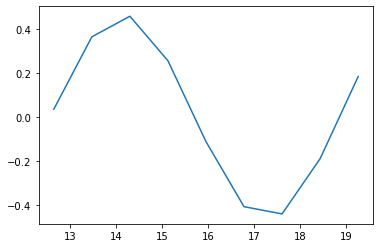

In [3]:
test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)
test_batch, test_event, test_time_to_event, test_latent_variable = next(iter(test_data_loader))
test_batch = test_batch.to(DEVICE)

plt.plot(np.array(test_batch.cpu()[0][:int(test_time_to_event[0]),1]), test_batch.cpu()[0][:int(test_time_to_event[0]),2])
print(test_batch[0,:10])
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))

In [4]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, CauseSpecificSubnetwork
from losses import loss_1

poc_raw_dataset = PocDataset(num_cases=2**6)
data_loader = torch.utils.data.DataLoader(poc_raw_dataset,batch_size=1)

NUM_EPOCHS = 20

LEARNING_RATE_ENCODER = 0.001
LEARNING_RATE_DECODER = 0.001
LEARNING_RATE_REGRESS = 0.001
LEARNING_RATE_CAUSESS = 0.0005

LOSS_1_AMPLIFIER = 1
LOSS_3_AMPLIFIER = 1
LOSS_4_AMPLIFIER = 0

input_size = 3
output_size = input_size
MAX_LENGTH = 20
NUM_CAUSES = 2
hidden_size_encoder = 128
hidden_size_regress = 128
fc_size_encoder = 256

# initialize model
encoder = EncoderRNN(input_size, hidden_size_encoder, fc_size_encoder).to(DEVICE)
decoder = AttnDecoderRNN(hidden_size_encoder, output_size, MAX_LENGTH).to(DEVICE)
#regress = RegressionNetwork(hidden_size_encoder, hidden_size_regress).to(DEVICE)
causess = CauseSpecificSubnetwork(hidden_size_encoder, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER)
#optimizer_regress = Adam(regress.parameters(), lr=LEARNING_RATE_REGRESS)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS)
 
# initialize loss
mse_loss = MSELoss()
writer = SummaryWriter()

In [5]:
import time

total_time = 0
its = 0

# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  optimizer_encoder.zero_grad()
  optimizer_decoder.zero_grad()
  #optimizer_regress.zero_grad()
  optimizer_causess.zero_grad()
  

  for i, data in enumerate(data_loader):

    its += 1
    

    batch, event, time_to_event, _latent_variable = data

    batch = batch.to(DEVICE)
    event = event.to(DEVICE)
    time_to_event = time_to_event.to(DEVICE)
    _latent_variable = _latent_variable.to(DEVICE)

    encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=DEVICE)
    encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size, device=DEVICE)
    encoder_hidden = encoder.initHidden(device=DEVICE)

    for ei in range(batch.size(1)):
        encoder_input = batch[0][ei].view(1,1,-1)
        encoder_output, encoder_hidden = encoder(encoder_input, encoder_hidden)
        encoder_hidden_vector[ei] = encoder_hidden[0,0]
        encoder_output_vector[ei] = encoder_output
    
    last_measurement = batch[0][ei]
    context_vector = decoder(last_measurement, encoder_hidden_vector)
    first_hitting_time = causess(context_vector, last_measurement)

    
    loss1 = loss_1(first_hitting_time, event, time_to_event, MAX_LENGTH)
    loss3 = mse_loss(encoder_output_vector[:-1], batch.detach().squeeze(0)[1:])

    epoch_loss += LOSS_1_AMPLIFIER*loss1 + LOSS_3_AMPLIFIER*loss3

  writer.add_scalar('loss1', loss1.item(), epoch*len(data_loader) + i)
  writer.add_scalar('loss3', loss3.item(), epoch*len(data_loader) + i)
  writer.add_scalar('loss_epoch', epoch_loss.item(), epoch)

  epoch_loss.backward()

  start = time.time()
  optimizer_encoder.step()
  optimizer_decoder.step()
  optimizer_causess.step()
  end = time.time()
  total_time += end - start

  
  
print("av_epoch_train_loss=", epoch_loss.item()/len(data_loader))

100%|██████████| 20/20 [00:52<00:00,  2.61s/it]

av_epoch_train_loss= 137.7313690185547


In [6]:
print(total_time/NUM_EPOCHS)
print(its)
print(total_time)

0.0022478818893432615
1280
0.044957637786865234


* zero grad time = 0.0006914854049682618
* initialising vector time = 0.0005470195785164834
* encoder forward = 0.012803261168301105 @ NUM_EPOCHS*MAX_LENGTH ~ 40%
* decoder forward = 0.0003232633695006371
* causess forward = 0.00042380280792713164
* computing losses = 0.00033656619489192964
* backwards computation = 1.441696321964264 @ NUM_EPOCHS ~60%

tensor([[ 5.5005e+00,  5.6528e+00, -2.3848e-02],
        [ 9.6709e+00,  9.7914e+00, -3.1327e-02],
        [ 1.2491e+01,  1.2505e+01, -3.4648e-02],
        [ 1.4081e+01,  1.4002e+01, -3.0811e-02],
        [ 1.4913e+01,  1.4775e+01, -2.5024e-02],
        [ 1.5377e+01,  1.5208e+01, -2.1296e-02],
        [ 1.5679e+01,  1.5494e+01, -1.9105e-02],
        [ 1.5906e+01,  1.5712e+01, -1.7810e-02],
        [ 1.6090e+01,  1.5893e+01, -1.7172e-02],
        [ 9.1561e+00,  8.9126e+00,  6.8234e-03]], device='cuda:0')
event=0, time_to_event=9, latent_variable=0.465103


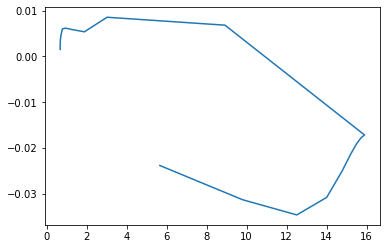

In [7]:
test_encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=DEVICE)
test_encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size, device=DEVICE)
test_encoder_hidden = encoder.initHidden(device=DEVICE)

for ei in range(test_batch.size(1)):
        test_encoder_input = test_batch[0][ei].view(1,1,-1)
        test_encoder_output, test_encoder_hidden = encoder(test_encoder_input, test_encoder_hidden)
        test_encoder_output_vector[ei] = test_encoder_output

test_last_measurement = test_batch[0][ei]
test_context_vector = decoder(test_last_measurement, test_encoder_hidden_vector)
#test_estimated_latent_variable = regress(test_context_vector)
test_first_hitting_time = causess(test_context_vector, test_last_measurement)

test_encoder_output_vector = test_encoder_output_vector.unsqueeze(0).detach()
plt.plot(np.array(test_encoder_output_vector.cpu()[0][0:23,1]), test_encoder_output_vector.cpu()[0][0:23,2])
print(test_encoder_output_vector[0,:10])
#print("real lv was %f, we estimated %f" % (test_latent_variable.item(), test_estimated_latent_variable.item()))
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))